## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca

In [2]:
features = []
remote_folder = 'Gel_Studies/11_21_18_coverage' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 20
gels = ['PSCOOH', 'p0_1', 'p0_2', 'p0_4', 'p0_5', 'p0_6', 'p0_75', 'p1']
nonnum = ['Excess', 'Well', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
featofvar = 'Excess'

counter = 0
for gel in gels:
    for num in range(1, vids+1):
        try:
            filename = 'features_{}_XY{}.csv'.format(gel, '%02d' % num)
            aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name='ccurtis.data')
            fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
            print('{} size: {}'.format(filename, fstats.shape))
            fstats['Excess'] = pd.Series(fstats.shape[0]*[gel], index=fstats.index)
            fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
            if num < 11:
                fstats['Well'] = pd.Series(fstats.shape[0]*[1], index=fstats.index)
            else:
                fstats['Well'] = pd.Series(fstats.shape[0]*[2], index=fstats.index)
            counter = counter + 1
            if counter == 1:
                fstats_tot = fstats
            else:
                fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        except:
            print('skip filename {}'.format(filename))

features_PSCOOH_XY01.csv size: (5486, 67)
features_PSCOOH_XY02.csv size: (5414, 67)
features_PSCOOH_XY03.csv size: (5611, 67)
features_PSCOOH_XY04.csv size: (6137, 67)
features_PSCOOH_XY05.csv size: (6319, 67)
features_PSCOOH_XY06.csv size: (5908, 67)
features_PSCOOH_XY07.csv size: (5220, 67)
features_PSCOOH_XY08.csv size: (7149, 67)
features_PSCOOH_XY09.csv size: (6193, 67)
features_PSCOOH_XY10.csv size: (6890, 67)
features_PSCOOH_XY11.csv size: (5841, 67)
features_PSCOOH_XY12.csv size: (4816, 67)
features_PSCOOH_XY13.csv size: (5448, 67)
features_PSCOOH_XY14.csv size: (6064, 67)
features_PSCOOH_XY15.csv size: (6267, 67)
features_PSCOOH_XY16.csv size: (5839, 67)
features_PSCOOH_XY17.csv size: (6382, 67)
features_PSCOOH_XY18.csv size: (5896, 67)
features_PSCOOH_XY19.csv size: (6213, 67)
features_PSCOOH_XY20.csv size: (6492, 67)
features_p0_1_XY01.csv size: (2553, 67)
features_p0_1_XY02.csv size: (5528, 67)
features_p0_1_XY03.csv size: (5790, 67)
features_p0_1_XY04.csv size: (5356, 67)


In [3]:
fstats_tot['Excess Thresh'] = fstats_tot['Excess'].replace(['p0_4', 'p0_5', 'p0_6', 'p0_75', 'p1'], 'HI')

In [4]:
nonnum = ['Excess', 'Excess Thresh', 'Well', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y', 'Quality',
          'Mean_Intensity', 'SN_Ratio', 'Mean X', 'Std X', 'Mean Y', 'Std Y', 'Mean Quality', 'Std Quality', 'Mean SN_Ratio',
          'Std SN_Ratio', 'binx', 'biny', 'bins']

## Train-Test Split

In [5]:
bins = list(range(0, 2048+1, 256))
fstats_tot['binx'] = pd.cut(fstats_tot.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['biny'] = pd.cut(fstats_tot.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7])
fstats_tot['bins'] = 8*fstats_tot['binx'] + fstats_tot['biny']
fstats_tot = fstats_tot[np.isfinite(fstats_tot.bins)]
fstats_tot.bins = fstats_tot.bins.astype(int)

In [6]:
# cols = fstats_tot.columns.tolist()
# cols = cols[-3:] + cols[:-3]
# pcadataset.final = pcadataset.final[cols]

def checkerboard(size):
    rows = int(size/2)
    checks = list(range(0, size*size, size+1))
    
    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(2*i + (size+1)*j)

    for i in range(1, rows):
        ssize = size - 2*i
        for j in range(0, ssize):
            checks.append(size*size - 1 - (2*i + (size+1)*j))
    checks.sort()
    return checks

In [7]:
#featofvar = 'Particle Type'
#ncomp = 15

# X_train = pcadataset.final[pcadataset.final.bins.isin(checkerboard(8))].values[:, -ncomp:]
# X_test = pcadataset.final[~pcadataset.final.bins.isin(checkerboard(8))].values[:, -ncomp:]
# y_train = pcadataset.final[pcadataset.final.bins.isin(checkerboard(8))][featofvar].values
# y_test = pcadataset.final[~pcadataset.final.bins.isin(checkerboard(8))][featofvar].values

f_train = fstats_tot[fstats_tot.bins.isin(checkerboard(8))].reset_index()
f_test = fstats_tot[~fstats_tot.bins.isin(checkerboard(8))].reset_index()

# for run in range(1):
#     clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
#                         alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
#                         early_stopping=True, validation_fraction=0.1)

#     clf.fit(X_train, y_train)
    
#     print('Training Results')
#     y_true1, y_pred1 = y_train, clf.predict(X_train)
#     print(classification_report(y_true1, y_pred1, digits=4))
    
#     print('Test Results')
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred, digits=4))

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [8]:
ncomp = 13
pca_train = pca.pca_analysis(f_train, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.2941498712354396
1 component: 0.4232120037238735
2 component: 0.5044256586863571
3 component: 0.5703112966396867
4 component: 0.6110143462978659
5 component: 0.6482135182780605
6 component: 0.6784941971331462
7 component: 0.705878075386819
8 component: 0.7311105393689512
9 component: 0.7553295962520794
10 component: 0.7780387536216229
11 component: 0.7996515029578452
12 component: 0.8193398107206032


In [9]:
kmostat = pca.kmo(pca_train.scaled)

0.907761634941


In [10]:
pca_train.final.head()

,index,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,3,4,5,6,7,8,9,10,11,12
0,2,2.0,2.081122e-09,0.045668,3.458635,0.128635,0.687053,0.017355,1.052605,0.049976,...,0.675075,3.296704,0.195167,0.680659,2.318813,2.106433,-1.495990,-0.846589,0.963741,0.764041
1,3,3.0,2.129315e-02,0.688365,3.669061,0.124442,0.691704,0.016745,1.103457,0.093757,...,5.247122,3.807409,-0.788171,2.449243,2.549543,-0.581361,1.677633,-3.006163,-1.943074,0.434126
2,4,4.0,1.331803e-04,0.059855,2.870541,0.091255,0.732119,0.012031,1.221362,0.181242,...,0.279606,4.935713,0.658969,2.067474,1.690937,1.580907,-1.630678,0.673288,1.621762,0.794912
3,5,5.0,8.035373e-03,0.340567,4.643719,0.239680,0.585379,0.034797,2.252992,0.556146,...,6.090514,7.085516,-0.748318,1.284440,0.213562,0.697589,1.490856,-1.204143,2.570200,0.324561
4,6,6.0,1.275875e-09,0.071506,2.816658,0.451766,0.442804,0.077498,1.146131,0.127500,...,0.424503,4.543431,0.101174,1.960774,1.015020,2.054916,-1.529682,0.401220,1.846543,0.949711


In [11]:
pca_test = pca.pca_analysis(f_test, dropcols=nonnum, n_components=ncomp, existing_model=True, model_file=pca_train)

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [12]:
import numpy as np
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pca_train.final[pca_train.final['Excess']=='PSCOOH'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pca_train.final[pca_train.final['Excess']=='p0_1'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pca_train.final[pca_train.final['Excess']=='p0_2'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pca_train.final[pca_train.final['Excess']=='p0_4'].values[:, -ncomp:], axis=0)
dicti[4] = np.nanmean(pca_train.final[pca_train.final['Excess']=='p0_5'].values[:, -ncomp:], axis=0)
dicti[5] = np.nanmean(pca_train.final[pca_train.final['Excess']=='p0_6'].values[:, -ncomp:], axis=0)
dicti[6] = np.nanmean(pca_train.final[pca_train.final['Excess']=='p0_75'].values[:, -ncomp:], axis=0)
dicti[7] = np.nanmean(pca_train.final[pca_train.final['Excess']=='p1'].values[:, -ncomp:], axis=0)

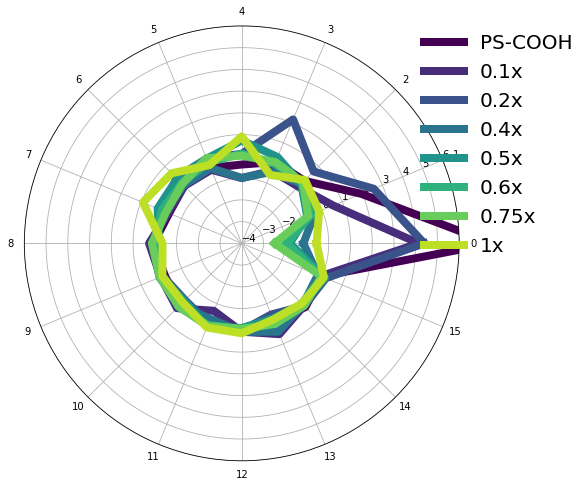

In [9]:
pca.plot_pca(dicti, savefig=True, labels=['PS-COOH', '0.1x', '0.2x', '0.4x', '0.5x', '0.6x', '0.75x', '1x'],
             rticks=np.linspace(-4, 9, 14))

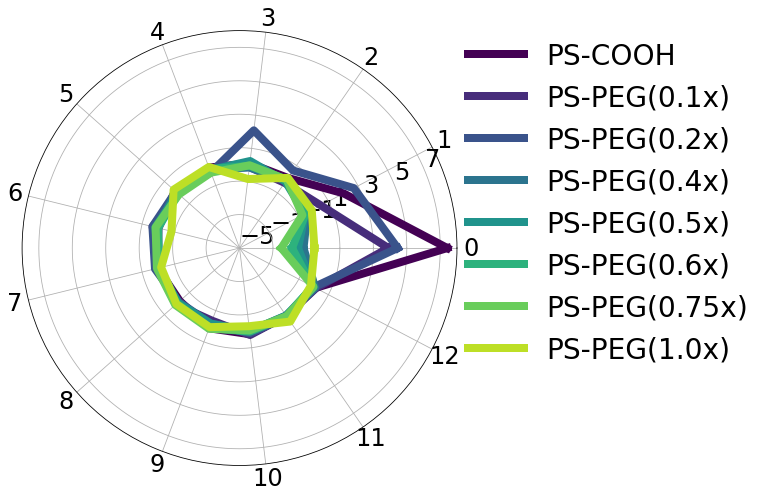

In [14]:
labels = gels
labels2 = ['PS-COOH', 'PS-PEG(0.1x)', 'PS-PEG(0.2x)', 'PS-PEG(0.4x)', 'PS-PEG(0.5x)',
           'PS-PEG(0.6x)', 'PS-PEG(0.75x)', 'PS-PEG(1.0x)']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-5, 7, 7), dpi=1200, labelsize=24,
             filename='pics/coverage_pcaavg.png')

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import cm

def feature_violin(df, label='label', lvals=['yes', 'no'], labels=['yes', 'no'], fsubset=3, **kwargs):
    """Creates violinplot of input feature dataset

    Designed to plot PCA components from pca_analysis.

    Parameters
    ----------
    df : pandas.core.frames.DataFrame
        Must contain a group name column, and numerical feature columns.
    label : string or int
        Name of group column.
    lvals : list of string or int
        All values that group column can take
    fsubset : int or list of int
        Features to be plotted. If integer, will plot range(fsubset).
        If list, will only plot features contained in fsubset.
    **kwargs : variable
        figsize : tuple of int or float
            Dimensions of output figure
        yrange : list of int or float
            Range of y axis
        xlabel : string
            Label of x axis
        labelsize : int or float
            Font size of x label
        ticksize : int or float
            Font size of y tick labels
        fname : None or string
            Name of output file
        legendfontsize : int or float
            Font size of legend
        legendloc : int
            Location of legend in plot e.g. 1, 2, 3, 4

    """

    defaults = {'figsize': (12, 5), 'yrange': [-20, 20], 'xlabel': 'Feature',
                'labelsize': 20, 'ticksize': 16, 'fname': None,
                'legendfontsize': 12, 'legendloc': 1}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    # Restacking input data
    groupsize = []
    featcol = []
    valcol = []
    feattype = []

    if isinstance(fsubset, int):
        frange = range(fsubset)
    else:
        frange = fsubset

    for feat in frange:
        groupsize.extend(df[label].values)
        featcol.extend([feat]*df[label].values.shape[0])
        valcol.extend(df[feat].values)

    to_violind = {'label': groupsize, 'Feature': featcol,
                  'Feature Value': valcol}
    to_violin = pd.DataFrame(data=to_violind)

    # Plotting function
    fig, ax = plt.subplots(figsize=kwargs['figsize'])
    sns.violinplot(x="Feature", y="Feature Value", hue="label", data=to_violin,
                   palette=cm.viridis(np.linspace(0, 0.9, 8))[0:4], hue_order=lvals,
                   figsize=kwargs['figsize'], linewidth=0)

    # kwargs
    ax.tick_params(axis='both', which='major', labelsize=kwargs['ticksize'])
    plt.xlabel('Feature', fontsize=kwargs['labelsize'])
    plt.ylabel('Normalized\nFeature Space', fontsize=kwargs['labelsize'])
    plt.ylim(kwargs['yrange'])
    plt.setp(ax.collections, alpha=.75)
    L=ax.legend(loc='upper right', prop={'size': 18})
    for item, label in zip(L.get_texts(), labels):
        item.set_text(label)
    #ax.legend(prop={'size': 18})
    
    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'], dpi=300, pad_inches=0.22)

    return to_violin

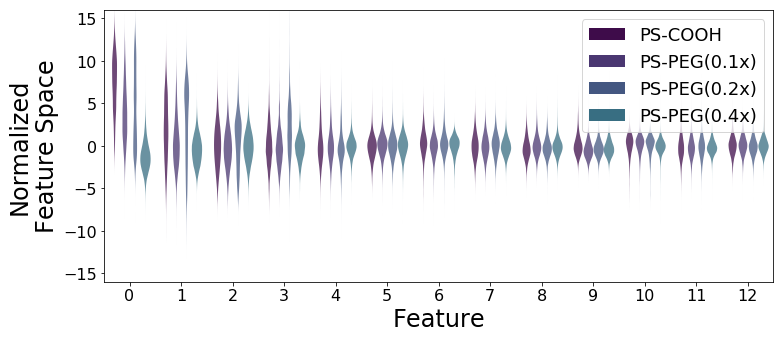

In [21]:
feats = feature_violin(pca_train.final[pca_train.final.Excess.isin(gels[0:4])], label='Excess', lvals=gels[0:4], labels=labels2, fsubset=ncomp, yrange=[-16, 16],
                       legendfontsize=21, labelsize=24, fname='./pics/coverage_pcadist1.png')

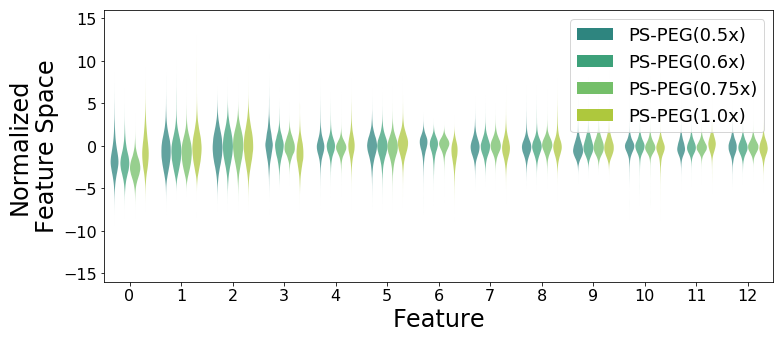

In [18]:
feats = feature_violin(pca_train.final[pca_train.final.Excess.isin(gels[4:8])], label='Excess', lvals=gels[4:8], labels=labels2[4:8], fsubset=ncomp, yrange=[-16, 16],
                       legendfontsize=21, labelsize=24, fname='./pics/coverage_pcadist2.png')

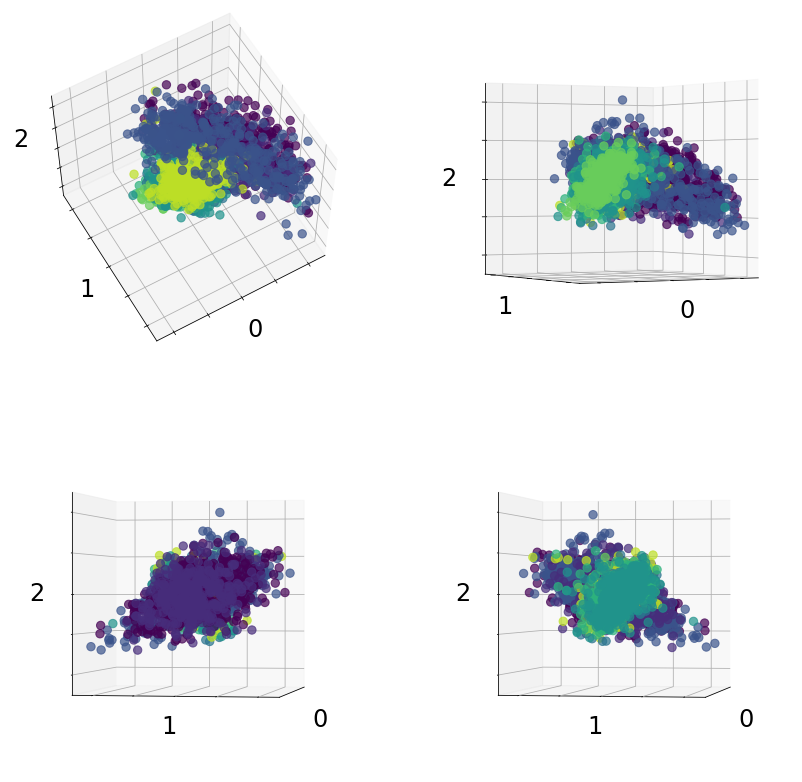

In [19]:
fstats1 = pca.feature_plot_3D(pca_train.final, label='Excess', lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], legendfontsize=24, labelfontsize=24, dpi=1600,
                              ticksize=20,
                              fname='./pics/coverage_3feats.png')

## Neural Network

In [22]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [23]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final[featofvar].values
y_test = pca_test.final[featofvar].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 1.20646901
Validation score: 0.534696
Iteration 2, loss = 1.16341468
Validation score: 0.541652
Iteration 3, loss = 1.14575900
Validation score: 0.544611
Iteration 4, loss = 1.13154148
Validation score: 0.548035
Iteration 5, loss = 1.11849363
Validation score: 0.557470
Iteration 6, loss = 1.10685094
Validation score: 0.563698
Iteration 7, loss = 1.09646157
Validation score: 0.561560
Iteration 8, loss = 1.08615743
Validation score: 0.576061
Iteration 9, loss = 1.07632997
Validation score: 0.569353
Iteration 10, loss = 1.06879498
Validation score: 0.577610
Iteration 11, loss = 1.06031590
Validation score: 0.578462
Iteration 12, loss = 1.05233682
Validation score: 0.590794
Iteration 13, loss = 1.04524137
Validation score: 0.601531
Iteration 14, loss = 1.03958779
Validation score: 0.592777
Iteration 15, loss = 1.03295777
Validation score: 0.593831
Iteration 16, loss = 1.02851634
Validation score: 0.591770
Validation score did not improve more than tol=0.000010 for two c

In [24]:
X_train = pca_train.final.values[:, -ncomp:]
X_test = pca_test.final.values[:, -ncomp:]
y_train = pca_train.final['Excess Thresh'].values
y_test = pca_test.final['Excess Thresh'].values

for run in range(1):
    clf = MLPClassifier(hidden_layer_sizes=(900, ), solver='sgd', verbose=True, max_iter=500, tol=0.00001,
                        alpha=0.001, batch_size=50, learning_rate_init=0.005, learning_rate='adaptive',
                        early_stopping=True, validation_fraction=0.1)

    clf.fit(X_train, y_train)

    print('Training Results')
    y_true1, y_pred1 = y_train, clf.predict(X_train)
    print(classification_report(y_true1, y_pred1, digits=4))

    print('Test Results')
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4))

Iteration 1, loss = 0.24832365
Validation score: 0.904194
Iteration 2, loss = 0.23229750
Validation score: 0.905263
Iteration 3, loss = 0.22643588
Validation score: 0.909028
Iteration 4, loss = 0.22131177
Validation score: 0.911382
Iteration 5, loss = 0.21693550
Validation score: 0.915163
Iteration 6, loss = 0.21250625
Validation score: 0.913242
Iteration 7, loss = 0.20855078
Validation score: 0.918199
Iteration 8, loss = 0.20465060
Validation score: 0.918246
Iteration 9, loss = 0.20141039
Validation score: 0.921515
Iteration 10, loss = 0.19791630
Validation score: 0.918447
Iteration 11, loss = 0.19450149
Validation score: 0.924768
Iteration 12, loss = 0.19176078
Validation score: 0.927572
Iteration 13, loss = 0.18870827
Validation score: 0.926472
Iteration 14, loss = 0.18626252
Validation score: 0.930221
Iteration 15, loss = 0.18398380
Validation score: 0.932235
Iteration 16, loss = 0.18123528
Validation score: 0.930733
Iteration 17, loss = 0.17972951
Validation score: 0.932576
Iterat

In [6]:
pcadataset.final['Excess Thresh'] = pcadataset.final['Excess'].replace(['p0_4', 'p0_5', 'p0_6', 'p0_75', 'p1'], 'HI')
pcadataset.final = pcadataset.final[pcadataset.final.columns.tolist()[-1:] + pcadataset.final.columns.tolist()[:-1]]